In [2]:
import pandas as pd
import numpy as np
from scaling import standardize, normalize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from collections import Counter

import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, auc

from RandomForest import create_roc_curve, evaluate_rfc

In [4]:

df2015 = pd.read_csv('../data/kaasa/kaasa_2015.csv', index_col=None, header=0)
df2016 = pd.read_csv('../data/kaasa/kaasa_2016.csv', index_col=None, header=0)
df2017 = pd.read_csv('../data/kaasa/kaasa_2017.csv', index_col=None, header=0)
df2018 = pd.read_csv('../data/kaasa/kaasa_2018.csv', index_col=None, header=0)
df2019 = pd.read_csv('../data/kaasa/kaasa_2019.csv', index_col=None, header=0)
df2020 = pd.read_csv('../data/kaasa/kaasa_2020.csv', index_col=None, header=0)
df2021 = pd.read_csv('../data/kaasa/kaasa_2021.csv', index_col=None, header=0)

all_files = [df2015, df2016, df2017, df2018, df2019, df2020, df2021]

# All numeric features

In [4]:
df = pd.concat(all_files, axis=0, ignore_index=True)

df['date_time'] = pd.to_datetime(df['date_time'])

df = df.drop(columns=['source_id', 'individual', 'owner_id', 'name',  'distance', 'sin_time', 'cos_time', 'date_time',])
df = standardize(df, ['velocity', 'longitude', 'latitude', 'temperature', 'altitude']) # standarize the data
df = normalize(df, ['velocity', 'longitude', 'latitude', 'temperature', 'altitude'], 0, 1) # normalize the data

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('attack', axis=1), df['attack'], test_size=0.2, random_state=42)

In [144]:
# Create a random forest classifier model
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Train the model on the training set
rf.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = rf.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', round(accuracy*100, 2), "%")

Accuracy: 98.65 %


In [145]:
y_pred_count = Counter(y_pred)
y_test_count = y_test.value_counts()

print('y_test (faktisk):\n', y_test_count)
print('y_pred (predikert):', y_pred_count)

y_test (faktisk):
 0    47244
1      656
Name: attack, dtype: int64
y_pred (predikert): Counter({0: 47891, 1: 9})


              precision    recall  f1-score   support

           0       0.99      1.00      0.99     47244
           1       0.89      0.01      0.02       656

    accuracy                           0.99     47900
   macro avg       0.94      0.51      0.51     47900
weighted avg       0.99      0.99      0.98     47900



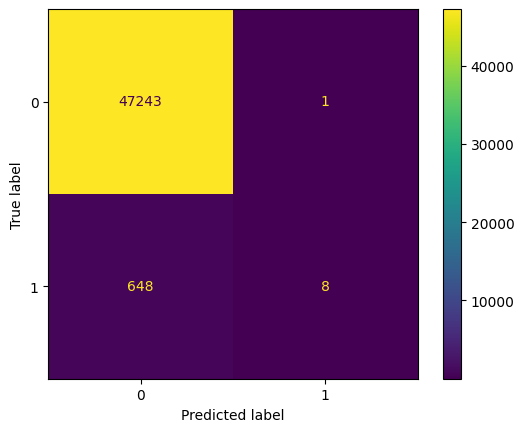

In [146]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)

disp.plot()
plt.show()

altitude importance:  0.08680072129348602
temperature importance:  0.20023602916732888
latitude importance:  0.19771428352081513
longitude importance:  0.2029285959770579
velocity importance:  0.23563337238305615
angle importance:  0.07668699765825603


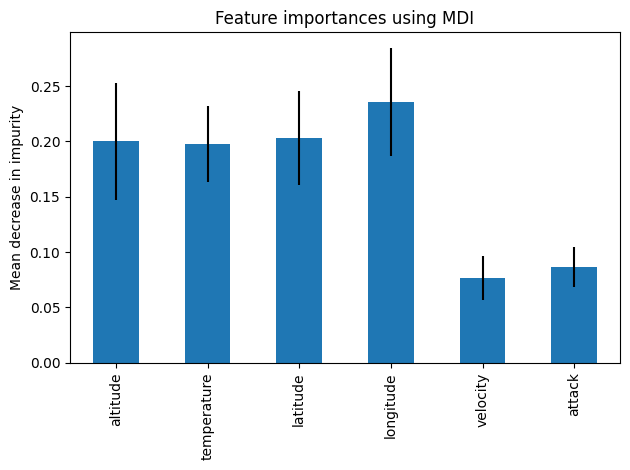

In [147]:
importances = rf.feature_importances_

feature_names = df.columns[:-1]
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

for i, feature in enumerate(X_train.columns):
    print(feature, 'importance: ', importances[i-1])

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [12]:
# Create a DataFrame of feature importances
df_importances = pd.DataFrame({'feature': df.columns[:-1], 'importance': importances})

# Create a bar chart of feature importances using Plotly Express
fig = px.bar(df_importances, x='importance', y='feature', orientation='h', title='Feature Importances')
fig.show()

# Tuning (only with velocity, angle and altitude)


In [90]:
df = pd.concat(all_files, axis=0, ignore_index=True)

df['date_time'] = pd.to_datetime(df['date_time'])

df = df.drop(columns=['source_id', 'individual', 'owner_id', 'name',  'distance', 'sin_time', 'cos_time', 'date_time',  'longitude', 'latitude', 'temperature'])
df = standardize(df, ['velocity', 'altitude', 'angle']) # standarize the data
df = normalize(df, ['velocity', 'altitude', 'angle'], 0, 1) # normalize the data

X = df.drop(['attack'], axis=1) # Features
y = df['attack'] # Target variable

Hyperparameter optimization

In [1]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameter grid to test
rs_space= {   
    'random_state': np.array([42, 123, 456]), 
    'n_estimators':np.arange(50, 500, step=50),
    'max_depth':list(np.arange(10, 100, step=10)) + [None],
    }

# Initialize and fit the random forest classifier
rf = RandomForestClassifier()

# First do a random search on a broad range of values
rf_random = RandomizedSearchCV(rf, rs_space, n_iter=200, scoring='recall', n_jobs=-1, cv=3)
model_random = rf_random.fit(X, y)

print('Best hyperparameters are: '+ str(model_random.best_params_))
print('Best score is: '+ str(model_random.best_score_))

NameError: name 'train_test_split' is not defined

In [ ]:
# Then narrow the grid space down for grid search, and use the values we got in random search
param_grid = {
    'random_state': [42, 123, 456],
    'n_estimators': [50, 100, 200],
}

grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='recall', n_jobs=-1)
grid_search.fit(X, y)

print("Optimal parameters: ", grid_search.best_params_)
print("Best recall score: ", grid_search.best_score_)

## No tuning, only hyperparam optimization

In [6]:
# Train the Random Forest Classifier on the balanced dataset
rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = rf.predict(X_test)

roc_auc_score for RandomForestClassifier:  0.5006775282859509
Best threshold: 1


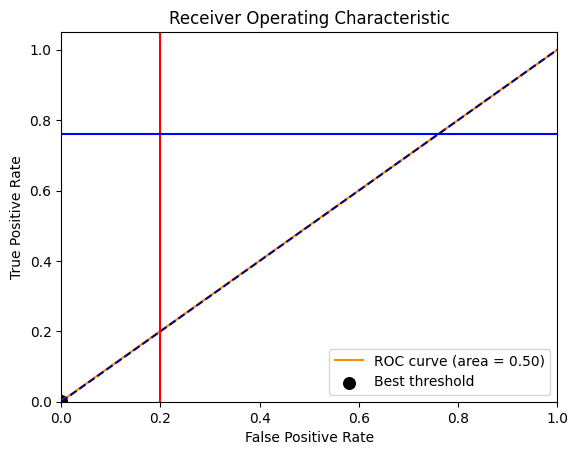

Accuracy: 98.62 %
[[47236     8]
 [  655     1]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     47244
           1       0.11      0.00      0.00       656

    accuracy                           0.99     47900
   macro avg       0.55      0.50      0.50     47900
weighted avg       0.97      0.99      0.98     47900



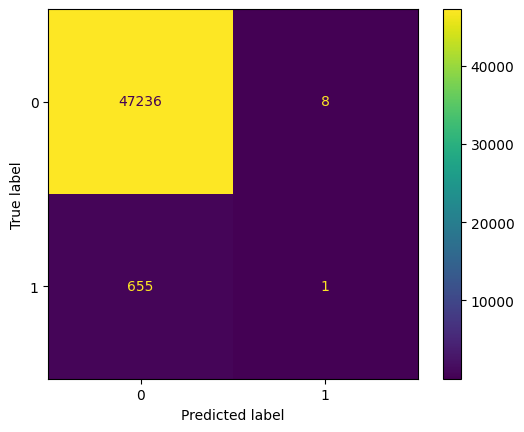

In [7]:
create_roc_curve(y_test=y_test, y_pred=y_pred)
evaluate_rfc(rf, y_test=y_test, y_pred=y_pred)

## Undersampling
In undersampling, you randomly remove some of the majority class instances to balance the dataset.

In [8]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

# Train the Random Forest Classifier on the balanced dataset
rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_train_res, y_train_res)

# Make predictions on the testing set
y_prob = rf.predict_proba(X_test)[:, 1] # Probabilities of positive class
y_pred = (y_prob > 0.5).astype(int) # Adjusting threshold to 0.5

roc_auc_score for RandomForestClassifier:  0.6998381263022688
Best threshold: 1


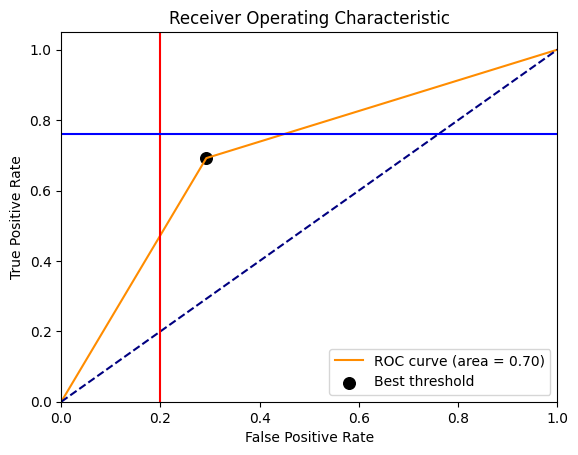

Accuracy: 70.74 %
[[33430 13814]
 [  202   454]]
              precision    recall  f1-score   support

           0       0.99      0.71      0.83     47244
           1       0.03      0.69      0.06       656

    accuracy                           0.71     47900
   macro avg       0.51      0.70      0.44     47900
weighted avg       0.98      0.71      0.82     47900



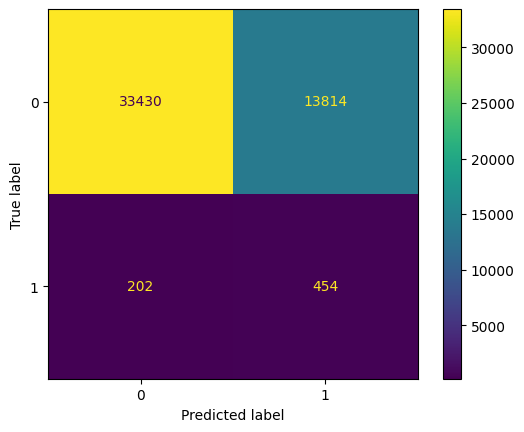

In [12]:
create_roc_curve(y_test, y_pred)
evaluate_rfc(rf, y_test, y_pred)

roc_auc_score for RandomForestClassifier:  0.8018885092648234
Best threshold: 1


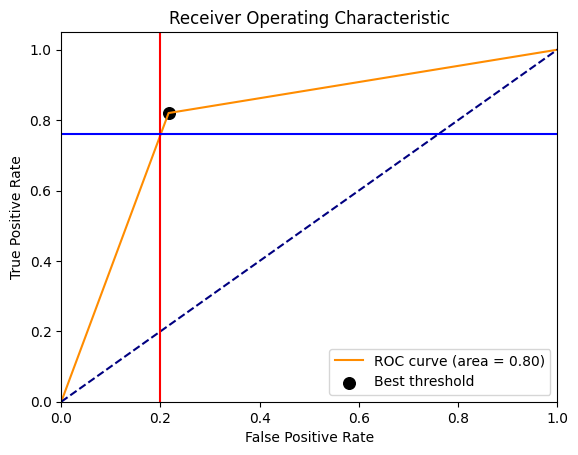

Accuracy: 78.42 %
[[37023 10221]
 [  118   538]]
              precision    recall  f1-score   support

           0       1.00      0.78      0.88     47244
           1       0.05      0.82      0.09       656

    accuracy                           0.78     47900
   macro avg       0.52      0.80      0.49     47900
weighted avg       0.98      0.78      0.87     47900



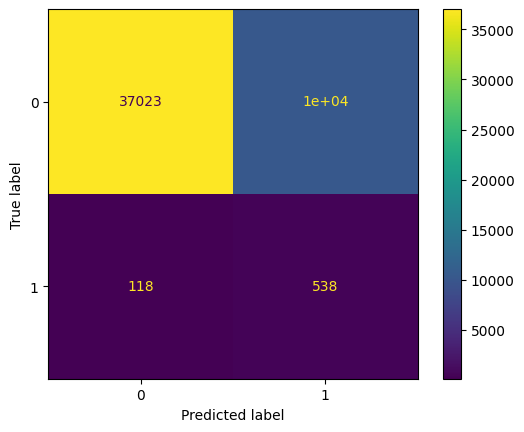

In [114]:
# Make predictions on the testing set
y_pred = (y_prob > 0.52).astype(int) # Adjusting threshold to 0.3

create_roc_curve(y_test, y_pred)
evaluate_rfc(rf, y_test, y_pred)

# Oversampling

In [115]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

# Train the Random Forest Classifier on the balanced dataset
rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_train_res, y_train_res)

# Make predictions on the testing set
y_pred = rf.predict_proba(X_test)[:, 1] # Probabilities of positive class

roc_auc_score for RandomForestClassifier:  0.86130118665217
Best threshold: 0.02


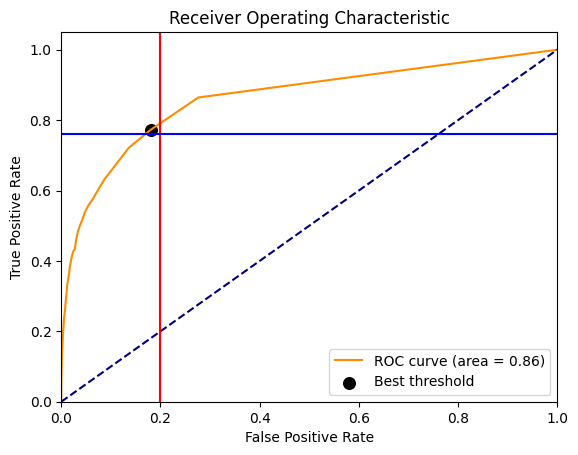

In [61]:
create_roc_curve(y_test, y_pred)

Accuracy: 98.66 %
[[47165    79]
 [  564    92]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     47244
           1       0.54      0.14      0.22       656

    accuracy                           0.99     47900
   macro avg       0.76      0.57      0.61     47900
weighted avg       0.98      0.99      0.98     47900



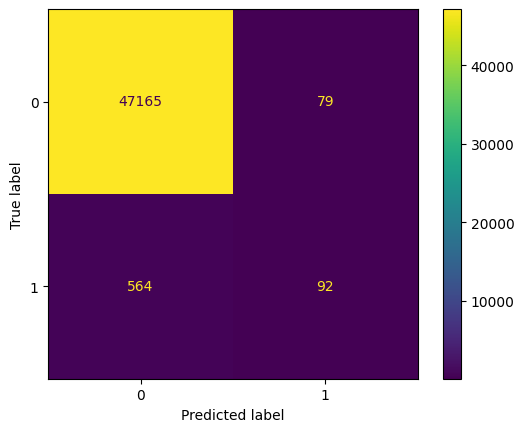

In [63]:
# Make predictions on the testing set
y_prob = rf.predict_proba(X_test)[:, 1] # Probabilities of positive class
y_pred = (y_prob > 0.5).astype(int) # Adjusting threshold

evaluate_rfc(rf, y_test, y_pred)

# Combination of under- and oversampling
Undersampling ga mye recall, mens oversampling ga mye precision. Prøve å kombinere begge.

In [64]:
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler

# define the combined sampling method
sampler = SMOTEENN(random_state=42)

# fit and apply the sampling method to the training data
X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)

# apply under-sampling to the majority class
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_resampled, y_train_resampled)

# train a random forest classifier on the resampled data
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# make predictions on the test set
y_prob = clf.predict_proba(X_test)[:, 1] # get probability of positive class

roc_auc_score for RandomForestClassifier:  0.8595417846323496
Best threshold: 0.11


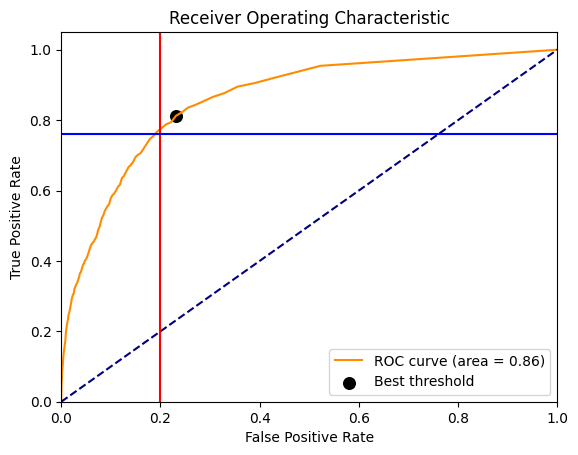

In [25]:
create_roc_curve(y_test, y_prob)

roc_auc_score for RandomForestClassifier:  0.6634850134537666
Best threshold: 1


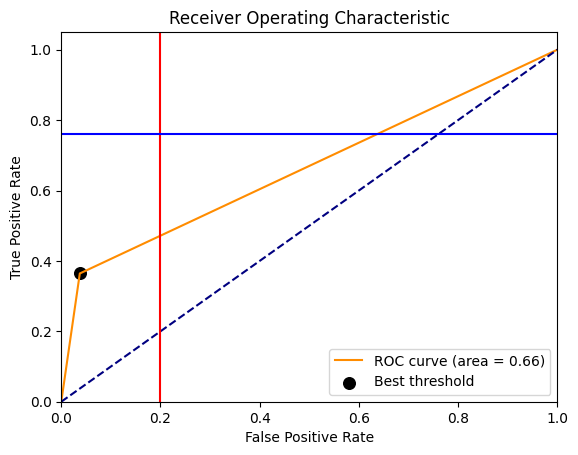

Accuracy: 95.44 %
[[45479  1765]
 [  417   239]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.98     47244
           1       0.12      0.36      0.18       656

    accuracy                           0.95     47900
   macro avg       0.56      0.66      0.58     47900
weighted avg       0.98      0.95      0.97     47900



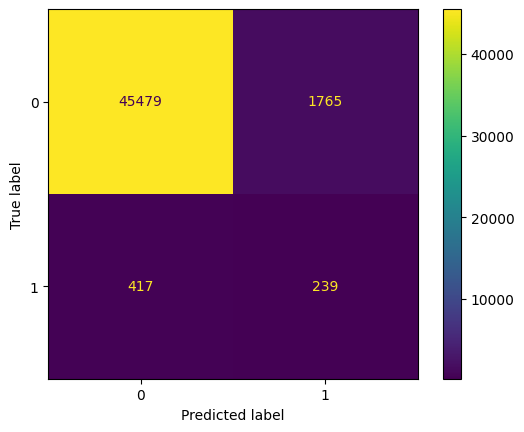

In [30]:
y_pred = (y_prob > 0.6).astype(int) # Adjusting threshold
create_roc_curve(y_test, y_pred)
evaluate_rfc(clf, y_test, y_pred)

# VELOCTITY, ANGLE + ALTITUDE
## Med bruk av stratified k fold technique

Using standard random forest (vanlig)

Mean f1: 0.007
Mean recall: 0.004
Mean precision: 0.226


C:\Users\emili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


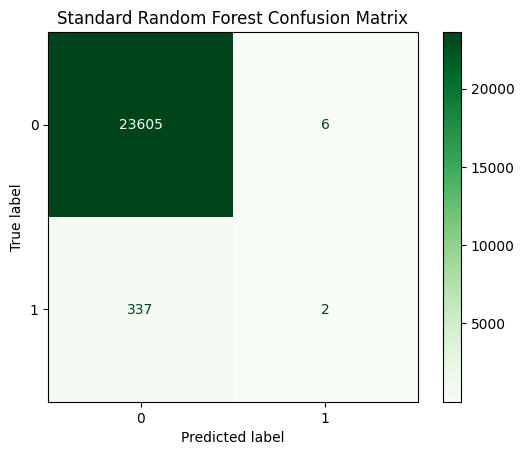

In [8]:
import matplotlib.pyplot as plt
from statistics import mean
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier

#Build SRF model
SRF = RandomForestClassifier(n_estimators=50, random_state=42)
#Create Stratified K-fold cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ('f1', 'recall', 'precision')
#Evaluate SRF model
scores = cross_validate(SRF, X, y, scoring=scoring, cv=cv)
#Get average evaluation metrics
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))

#Randomly spilt dataset to test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
#Train SRF
SRF.fit(X_train, y_train)
#SRF prediction result
y_pred = SRF.predict(X_test)
#Create confusion matrix
fig = plot_confusion_matrix(SRF, X_test, y_test, display_labels=['0', '1'], cmap='Greens')
plt.title('Standard Random Forest Confusion Matrix')
plt.show()

Using balanced random forest

Mean f1: 0.067
Mean recall: 0.723
Mean precision: 0.035


C:\Users\emili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


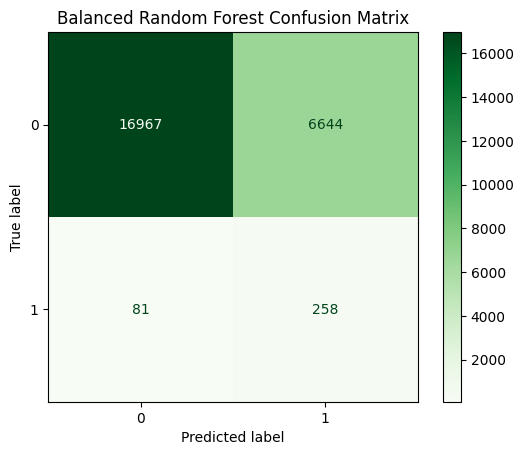

In [17]:
from imblearn.ensemble import BalancedRandomForestClassifier

#Build SRF model
BRFC = BalancedRandomForestClassifier(n_estimators=50, random_state=42)
#Create Stratified K-fold cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ('f1', 'recall', 'precision')
#Evaluate BRFC model
scores = cross_validate(BRFC, X, y, scoring=scoring, cv=cv)
#Get average evaluation metrics
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))

#Randomly spilt dataset to test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
#Train BRFC
BRFC.fit(X_train, y_train)
#BRFC prediction result
y_pred = BRFC.predict(X_test)

#Create confusion matrix
fig = plot_confusion_matrix(BRFC, X_test, y_test, display_labels=['0', '1'], cmap='Greens')
plt.title('Balanced Random Forest Confusion Matrix')
plt.show()

Using SMOTE and standard random forest

Mean f1: 0.941
Mean recall: 0.961
Mean precision: 0.922


C:\Users\emili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


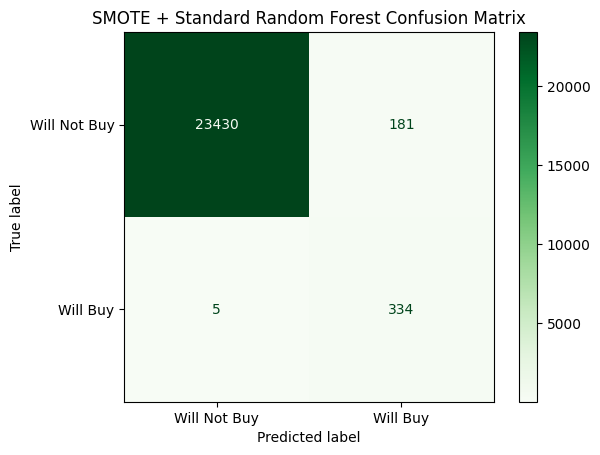

In [18]:
from imblearn.over_sampling import SMOTE

#Use SMOTE to oversample the minority class
oversample = SMOTE()
over_X, over_y = oversample.fit_resample(X, y)
over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, test_size=0.1, stratify=over_y)
#Build SMOTE SRF model
SMOTE_SRF = RandomForestClassifier(n_estimators=50, random_state=42)
#Create Stratified K-fold cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scoring = ('f1', 'recall', 'precision')
#Evaluate SMOTE SRF model
scores = cross_validate(SMOTE_SRF, over_X, over_y, scoring=scoring, cv=cv)
#Get average evaluation metrics
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))

#Randomly spilt dataset to test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
#Train SMOTE SRF
SMOTE_SRF.fit(over_X_train, over_y_train)
#SMOTE SRF prediction result
y_pred = SMOTE_SRF.predict(X_test)
#Create confusion matrix
fig = plot_confusion_matrix(SMOTE_SRF, X_test, y_test, display_labels=['0', '1'], cmap='Greens')
plt.title('SMOTE + Standard Random Forest Confusion Matrix')
plt.show()

# VELOCITY + ANGLE

In [5]:
import matplotlib.pyplot as plt
from statistics import mean
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier

df = pd.concat(all_files, axis=0, ignore_index=True)

df['date_time'] = pd.to_datetime(df['date_time'])

df = df.drop(columns=['source_id', 'individual', 'owner_id', 'name',  'distance', 'sin_time', 'cos_time', 'date_time',  'longitude', 'latitude', 'temperature', 'altitude'])
df = standardize(df, ['velocity', 'angle']) # standarize the data
df = normalize(df, ['velocity', 'angle'], 0, 1) # normalize the data

X = df.drop(['attack'], axis=1) # Features
y = df['attack'] # Target variable

using standard random forest + stratified k fold

In [10]:
#Build SRF model
SRF = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=100, n_jobs=-1)
#Create Stratified K-fold cross validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring = ('f1', 'recall', 'precision')
#Evaluate SRF model
scores = cross_validate(SRF, X, y, scoring=scoring, cv=cv)
#Get average evaluation metrics
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))

Mean f1: 0.014
Mean recall: 0.011
Mean precision: 0.021


Accuracy: 98.03 %
[[23473   138]
 [  334     5]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     23611
           1       0.03      0.01      0.02       339

    accuracy                           0.98     23950
   macro avg       0.51      0.50      0.51     23950
weighted avg       0.97      0.98      0.98     23950



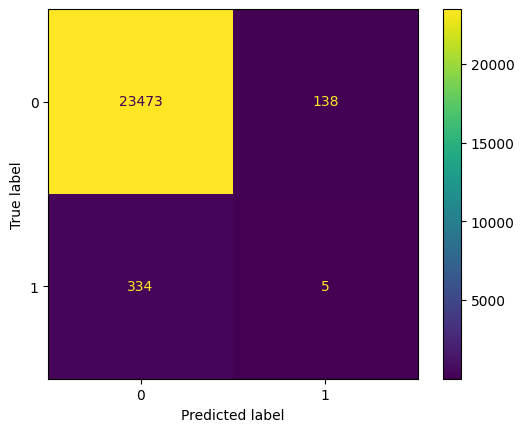

In [55]:
#Randomly spilt dataset to test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
#Train SRF
SRF.fit(X_train, y_train)
#SRF prediction result
y_pred = SRF.predict(X_test)

evaluate_rfc(SRF, y_test, y_pred)

using balanced random forest + stratified k fold

Mean f1: 0.031
Mean recall: 0.514
Mean precision: 0.016


C:\Users\emili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


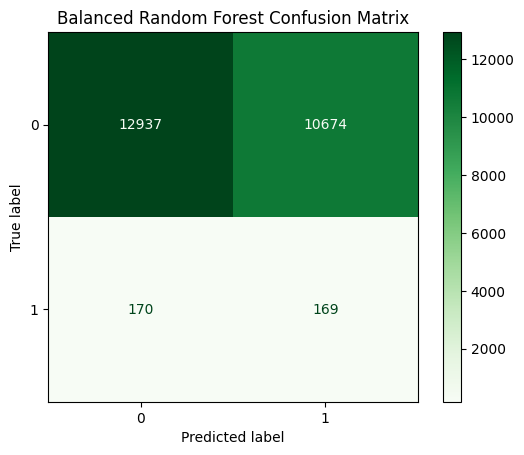

In [56]:
#Build SRF model
BRFC = BalancedRandomForestClassifier(n_estimators=100, random_state=42, max_depth=100, n_jobs=-1)
#Create Stratified K-fold cross validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring = ('f1', 'recall', 'precision')
#Evaluate BRFC model
scores = cross_validate(BRFC, X, y, scoring=scoring, cv=cv)
#Get average evaluation metrics
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))

#Randomly spilt dataset to test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
#Train BRFC
BRFC.fit(X_train, y_train)
#BRFC prediction result
y_pred = BRFC.predict(X_test)

#Create confusion matrix
fig = plot_confusion_matrix(BRFC, X_test, y_test, display_labels=['0', '1'], cmap='Greens')
plt.title('Balanced Random Forest Confusion Matrix')
plt.show()

Accuracy: 54.72 %
[[12937 10674]
 [  170   169]]
              precision    recall  f1-score   support

           0       0.99      0.55      0.70     23611
           1       0.02      0.50      0.03       339

    accuracy                           0.55     23950
   macro avg       0.50      0.52      0.37     23950
weighted avg       0.97      0.55      0.70     23950



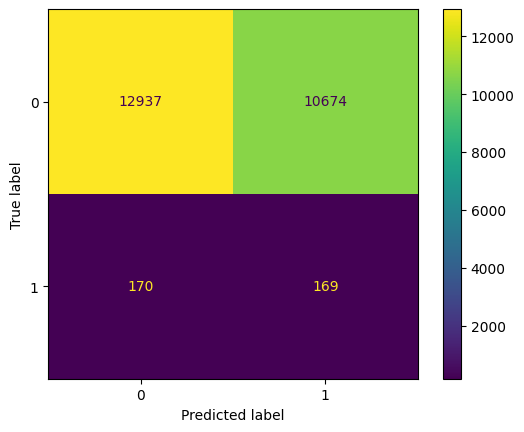

In [57]:
evaluate_rfc(BRFC, y_test, y_pred)

using SMOTE + standard random forest + stratified k fold

Mean f1: 0.898
Mean recall: 0.904
Mean precision: 0.893


C:\Users\emili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


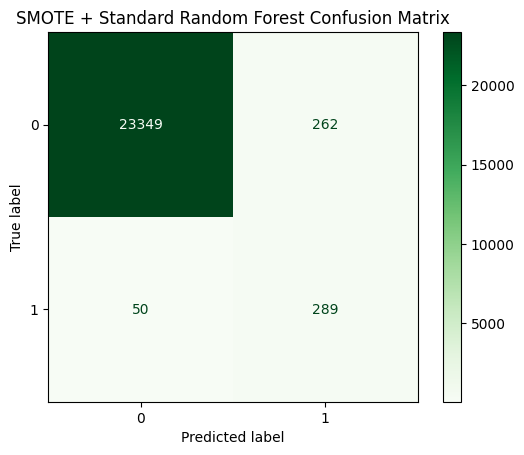

In [72]:
from imblearn.over_sampling import SMOTE

#Use SMOTE to oversample the minority class
oversample = SMOTE()
over_X, over_y = oversample.fit_resample(X, y)
over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, test_size=0.1, stratify=over_y)
#Build SMOTE SRF model
SMOTE_SRF = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=100, n_jobs=-1)
#Create Stratified K-fold cross validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
scoring = ('f1', 'recall', 'precision')
#Evaluate SMOTE SRF model
scores = cross_validate(SMOTE_SRF, over_X, over_y, scoring=scoring, cv=cv)
#Get average evaluation metrics
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))

#Randomly spilt dataset to test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
#Train SMOTE SRF
SMOTE_SRF.fit(over_X_train, over_y_train)
#SMOTE SRF prediction result
y_pred = SMOTE_SRF.predict(X_test)
#Create confusion matrix
fig = plot_confusion_matrix(SMOTE_SRF, X_test, y_test, display_labels=['0', '1'], cmap='Greens')
plt.title('SMOTE + Standard Random Forest Confusion Matrix')
plt.show()

Accuracy: 98.7 %
[[23349   262]
 [   50   289]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     23611
           1       0.52      0.85      0.65       339

    accuracy                           0.99     23950
   macro avg       0.76      0.92      0.82     23950
weighted avg       0.99      0.99      0.99     23950



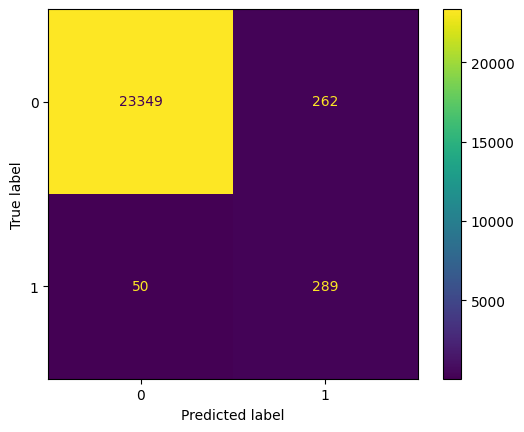

In [87]:
evaluate_rfc(SMOTE_SRF, y_test, y_pred)

In [ ]:
from imblearn.over_sampling import SMOTE

#Use SMOTE to oversample the minority class
oversample = SMOTE()
over_X, over_y = oversample.fit_resample(X, y)
over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, test_size=0.1, stratify=over_y)
#Build SMOTE SRF model
SMOTE_SRF = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=)
#Create Stratified K-fold cross validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
scoring = ('f1', 'recall', 'precision')
#Evaluate SMOTE SRF model
scores = cross_validate(SMOTE_SRF, over_X, over_y, scoring=scoring, cv=cv)
#Get average evaluation metrics
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))

#Randomly spilt dataset to test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
#Train SMOTE SRF
SMOTE_SRF.fit(over_X_train, over_y_train)
#SMOTE SRF prediction result
y_pred = SMOTE_SRF.predict(X_test)
#Create confusion matrix
fig = plot_confusion_matrix(SMOTE_SRF, X_test, y_test, display_labels=['0', '1'], cmap='Greens')
plt.title('SMOTE + Standard Random Forest Confusion Matrix')
plt.show()